About the dataset- The Cora dataset consists of 2708 scientific publications classified into one of seven classe(labels). 
The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. 
The dictionary consists of 1433 unique words.

A document is considered a node.
Citation here refers to a link or reference to other node(s).

Note: The citation network in the dataset is directed (Document A references document B, but note vice-versa), but for optimizing the training of our model, we'll consider it undirected.

In [1]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 5.1 MB/s 
     |████████████████████████████████| 482 kB 45.8 MB/s 
     |████████████████████████████████| 41 kB 496 kB/s 


In [2]:
#here we are importing all of the required libraries/functions which will be needed

import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
dataset = sg.datasets.Cora()
graph, unique_labels = dataset.load()

In [ ]:
# The info method can help us verify that our loaded graph matches the description or not
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [4]:
# the model we're buildig will predict the "unique label" for an unlabeled node of the dataset.
# here we have 7 unique labels and every document will belong to exactly one of them.
unique_labels.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


Here we will spilit our dataset into 3 parts:
1) Training sample,
2) Validation sample,
3) Testing Sample

In [47]:
# for training sample we are taking 200 node labels
train_set, test_set = model_selection.train_test_split(
    unique_labels, train_size=250, test_size=None, stratify=unique_labels
)

# for validation sample we are taking 300 node labels
val_set, test_set = model_selection.train_test_split(
    test_set, train_size=250, test_size=None, stratify=test_set
)

# all the remaining labels are left for testing sample.

In [48]:
# here are the labels and number of nodes for each label that we have taken in our training sample
train_set.value_counts().to_frame()

,subject
Neural_Networks,76
Genetic_Algorithms,39
Probabilistic_Methods,39
Theory,32
Case_Based,27
Reinforcement_Learning,20
Rule_Learning,17


In [49]:
# to get our categorical/class wise target, we will use one-hot vectors that will be compared against the model’s soft-max output. 
# this conversion we are doing with the help of LabelBinarizer transform ("docs") from scikit-learn

target_encoding = preprocessing.LabelBinarizer()
train_target = target_encoding.fit_transform(train_set) #encoding train sample
val_targets = target_encoding.transform(val_set)  #encoding validation sample
test_target = target_encoding.transform(test_set) #encoding test sample

In [50]:
# a data generator to convert the core graph structure and node features 
# into a format that can be fed into the Keras model for training or prediction
generator = FullBatchNodeGenerator(graph, method="gcn") #stellargraph has many genetators so we specify the method to "gcn".

Using GCN (local pooling) filters...


A generator just encodes the information required to produce the model inputs. Calling the flow method ("docs") with a set of nodes and their true labels produces an object that can be used to train the model, on those nodes and labels that were specified. Since we have created a training set above that’s what we’re going to use below for training.

In [51]:
train_gen = generator.flow(train_set.index, train_target)

In [64]:
# 3 layers were not optimal as during the back propagation, the backpropagated errors were almost dimnished
# 1 layers wasn't consitent and had fluctuating accuracy.
gcn = GCN(
    layer_sizes=[20, 20], activations=["relu", "relu"], generator=generator, dropout=0.5
)
# here we are modelling the layers, there are 2 layers both having 16 units each.
# each layer's output has been given to "ReLU" activation function.
# the dropout rate is 0.5 so an equal fraction of neurons will be shut and rest will get their values multiplied to get the same sum.

In [65]:
# To create a Keras model we now expose the input and output tensors (multi-dimensional vectors) of the GCN model for node prediction, via the GCN.in_out_tensors method: 
x_inp, x_out = gcn.in_out_tensors()

x_out # it is a TensorFlow tensor which is a 20 dimensional vector.
# The actual predictions of each node’s class/label needs to be computed from this vector.

<KerasTensor: shape=(1, None, 20) dtype=float32 (created by layer 'gather_indices_6')>

In [66]:
# For prediction we are taking an additional dense layer (with one unit per class) using a softmax activation. 
# This activation function ensures that the final outputs for each input node will be a vector of “probabilities”, 
# where every value is between 0 and 1, and the whole vector sums to 1. The predicted class is the element with the highest value.
print(train_target.shape[1])

predictions = layers.Dense(units=train_target.shape[1], activation="softmax")(x_out)

7


In [67]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy, # since we are doing categorical calssification, using categorical_crossentropy is apt
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [68]:
# to also keep track of its generalisation performance on the validation set
# which means creating another data generator, using our FullBatchNodeGenerator
val_gen = generator.flow(val_set.index, val_targets)

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)
# if our validation accuracy stops improving, we will use early stopping, it stops after 50 epochs (patience) give no improvement consecutively. 

In [70]:
# using the keras .fit method, we are training our model
history = model.fit(
    train_gen,
    epochs=500,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/500
1/1 - 1s - loss: 1.9513 - acc: 0.1280 - val_loss: 1.9087 - val_acc: 0.3120 - 1s/epoch - 1s/step
Epoch 2/500
1/1 - 0s - loss: 1.9029 - acc: 0.3240 - val_loss: 1.8624 - val_acc: 0.3080 - 150ms/epoch - 150ms/step
Epoch 3/500
1/1 - 0s - loss: 1.8500 - acc: 0.3360 - val_loss: 1.8002 - val_acc: 0.3120 - 148ms/epoch - 148ms/step
Epoch 4/500
1/1 - 0s - loss: 1.7780 - acc: 0.3280 - val_loss: 1.7206 - val_acc: 0.3200 - 158ms/epoch - 158ms/step
Epoch 5/500
1/1 - 0s - loss: 1.6972 - acc: 0.3640 - val_loss: 1.6340 - val_acc: 0.3480 - 152ms/epoch - 152ms/step
Epoch 6/500
1/1 - 0s - loss: 1.5697 - acc: 0.4120 - val_loss: 1.5488 - val_acc: 0.3840 - 147ms/epoch - 147ms/step
Epoch 7/500
1/1 - 0s - loss: 1.4922 - acc: 0.4040 - val_loss: 1.4657 - val_acc: 0.4480 - 193ms/epoch - 193ms/step
Epoch 8/500
1/1 - 0s - loss: 1.3790 - acc: 0.4720 - val_loss: 1.3828 - val_acc: 0.4960 - 181ms/epoch - 181ms/step
Epoch 9/500
1/1 - 0s - loss: 1.2808 - acc: 0.5240 - val_loss: 1.3040 - val_acc: 0.5720 - 181ms

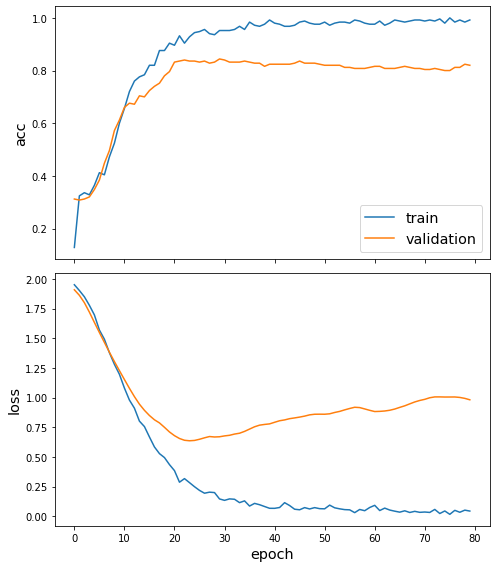

In [71]:
sg.utils.plot_history(history)
# here we are plotting the loss and accuracy on both training and validation sets

In [72]:
# using the similar generator, we generate our testing data for final check of the model
test_gen = generator.flow(test_set.index, test_target)

In [73]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 74ms/step - loss: 0.5969 - acc: 0.8297

Test Set Metrics:
	loss: 0.5969
	acc: 0.8297


In [74]:
# now we are going to perform the prediction of nodes, to do so we will this time give all the nodes to the generator and predict the labels of each of them
all_nodes = unique_labels.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [75]:
# The predictions were the output of the softmax layer, so to get final categories we’ll
# use the inverse_transform method of our target attribute specification to turn these values back to the original categories.
 
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [77]:
df = pd.DataFrame({"Predicted": node_predictions, "True": unique_labels})
df.head(10)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


As we can see above, 9/10 nodes were classified correctly.

To get a better and even clearer picture of how nodes are surrounded and where exactly they are in the space of dataset, we'll use the node embedding by colouring the different labels in different colours and plotting them altogether.

In [80]:
# To create a model for predicting node embedding we use the same model with just replacing the 
# x_out as the output tensors compared to GCN ones.
embedding_model = Model(inputs=x_inp, outputs=x_out)

# Note: The weights that were finally assigned in the node prediction models will be used here

In [82]:
emb = embedding_model.predict(all_gen)
emb.shape
# The last GCN layer had output dimension 20, meaning each embedding consists of 20 numbers. To plot this we'll project down these to 2 numbers 
# and then plot a 2d graph

(1, 2708, 20)

In [83]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE

In [85]:
# Since the embeddings from the GCN model have a batch dimension of 1 so we squeeze this to get a matrix of N(nodes)×M(emb).
X = emb.squeeze(0)
X.shape

(2708, 20)

In [86]:
# now that we have the high-dimensional vectors, we will use the transform method and project them in component size of 2.
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
# The X_reduced values contains a pair of numbers for each node
X_reduced.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for cora dataset'),
 None]

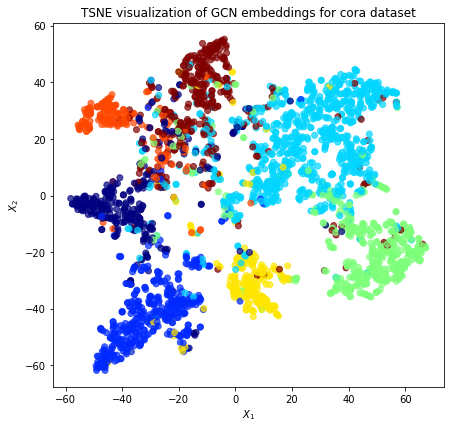

In [87]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=unique_labels.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for cora dataset",
)

Above we can see 7 different colours denoting the 7 unique_labels of the dataset. The classification makes them look distinguishable.